In [1]:
import os
from typing import Dict, Any
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from tavily import TavilyClient

In [2]:
load_dotenv()

True

In [3]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY")
)

In [4]:
@tool
def web_search(question:str)->Dict[str, Any]:
    """
    This returns top search results for a given search query
    
    Args:
        question (str): A query to be searched
    
    Returns:
        Dict[str, Any]: A dictionary containing a list of results (url, title, content, score)
    """
    response = tavily_client.search(
        query=question,
        max_results=5,
    )
    return response

In [5]:
message = "Who voiced Count Dracula in Hotel Transylvania 4?"

In [6]:
web_search.invoke(
    {
        "question": message
    }
)

{'query': 'Who voiced Count Dracula in Hotel Transylvania 4?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.voquent.com/blog/hotel-transylvania-4-voice-actors/?srsltid=AfmBOoqc0hWCkuyBV-lkNdKA0KdBL3Y4FUxZHnwJ3qJD5oiiOtybdP3R',
   'title': 'Hotel Transylvania 4 Voice Actors - Voquent',
   'content': 'Dracula (Brian Hull) · Mavis (Selena Gomez) · Johnny (Andy Samberg) · Frankenstein (Kevin James) · Wayne (Steve Buscemi) · Griffin (David Spade) · Murray (Keegan-',
   'score': 0.91901255,
   'raw_content': None},
  {'url': 'https://screenrant.com/hotel-transylvania-4-voice-cast-character-guide/',
   'title': 'Hotel Transylvania 4 Voice Cast: What The Characters Look Like In ...',
   'content': 'Brian Hull - Count Dracula ... YouTube personality and impressionist Brian Hull takes over from Adam Sandler in the Hotel Transylvania 4 cast as Count Dracula,',
   'score': 0.9049283,
   'raw_content': None},
  {'url': 'https://en.wikipedia.org/wik

In [7]:
tools = [web_search]

In [8]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## LLM with tools

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
llm_with_tools.invoke(message)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F7y6zxkZDlOpCjTl8YXVd10d', 'function': {'arguments': '{"question":"Count Dracula voice actor Hotel Transylvania 4"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 96, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9KRjkY8m7iAfsIfULvtEF0laMdHn', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e5c0c03e-0b82-4cf7-854d-bc3167d4abbd-0', tool_calls=[{'name': 'web_search', 'args': {'question': 'Count Dracula voice actor Hotel Transylvania 4'}, 'id': 'call_F7y6zxkZDlOpCjTl8YXVd10d', 'type': 'tool_call'}], usage_metadata={'in

## Graph from Scratch

In [11]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [12]:
def should_call_tool(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [13]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=should_call_tool, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


In [14]:
graph = workflow.compile()

In [15]:
type(graph)

langgraph.graph.state.CompiledStateGraph

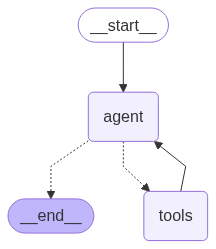

In [16]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [17]:
result = graph.invoke(
    input={
        "messages": message
    }
)

In [18]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Who voiced Count Dracula in Hotel Transylvania 4?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_bYC8MlYOTObinrNQaGjAE6zm)
 Call ID: call_bYC8MlYOTObinrNQaGjAE6zm
  Args:
    question: Count Dracula voice actor Hotel Transylvania 4
================================= Tool Message =================================
Name: web_search

{"query": "Count Dracula voice actor Hotel Transylvania 4", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.voquent.com/blog/hotel-transylvania-4-voice-actors/", "title": "Hotel Transylvania 4 Voice Actors - Voquent", "content": "Brian Hull , who voices the fatherly vampire, is an impressionist, a voice actor, and a popular YouTuber with more than 361 million views and 2.3 million subscribers. Voicing Dracula, he replaced the actor Adam Sandler, who gave Dracula his voice i

## Prebuilt

In [19]:
agent = create_react_agent(
    name="researcher_agent",
    model=llm,
    tools=tools,
)

In [20]:
type(agent)

langgraph.graph.state.CompiledStateGraph

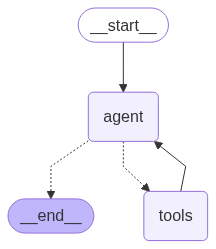

In [21]:
display(
    Image(
        agent.get_graph().draw_mermaid_png()
    )
)

In [22]:
result = agent.invoke(
    input={
        "messages": message
    }
)

In [23]:
for message in result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

In "Hotel Transylvania 4," titled "Hotel Transylvania: Transformania," Count Dracula is voiced by Brian Hull. He replaced Adam Sandler, who voiced Dracula in the first three films of the franchise.
================================== Ai Message ==================================
Name: researcher_agent
Tool Calls:
  web_search (call_cJZHulicCSRIrydVBA9kJdPL)
 Call ID: call_cJZHulicCSRIrydVBA9kJdPL
  Args:
    question: Hotel Transylvania 4 Dracula voice actor
================================= Tool Message =================================
Name: web_search

{"query": "Hotel Transylvania 4 Dracula voice actor", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.voquent.com/blog/hotel-transylvania-4-voice-actors/?srsltid=AfmBOoqtuoDYj2fOKCnFD3z5_q4iswDL4Rv20UNRtWm7MlLlg-Y4tMFF", "title": "Hotel Transylvania 4 Voice Actors - Voquent", "content": "Dracula (Brian Hull) · M